In [1]:
# Mount Drive if in Colab (safe to run locally)
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)
    IN_COLAB = True
except Exception:
    IN_COLAB = False

from pathlib import Path
import pandas as pd
import numpy as np

# Point to your CSV (adjust path if needed)
# e.g., "/content/StudentsPerformance.csv" or local path
DATA_FILE = Path("/content/drive/MyDrive/StudentsPerformance.csv")
assert DATA_FILE.exists(), f"File not found: {DATA_FILE}"

# Load + standardize column names for convenience
df = pd.read_csv(DATA_FILE)
df = df.rename(columns={
    "race/ethnicity":"race",
    "parental level of education":"parent_edu",
    "test preparation course":"test_prep",
    "math score":"math",
    "reading score":"reading",
    "writing score":"writing",
})
df["avg_score"] = df[["math","reading","writing"]].mean(axis=1)
df["High_Performer"] = (df["avg_score"] >= 70).astype(int)

print(df.shape)
df.head(3)


Mounted at /content/drive
(1000, 10)


,gender,race,parent_edu,lunch,test_prep,math,reading,writing,avg_score,High_Performer
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,1
1,female,group C,some college,standard,completed,69,90,88,82.333333,1
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1


In [2]:
from sklearn.model_selection import train_test_split

# Classification target
y_clf = df["High_Performer"]
X_clf = df.drop(columns=["High_Performer", "avg_score"])

# Regression target
y_reg = df["avg_score"]
X_reg = df.drop(columns=["High_Performer", "avg_score"])

def coerce_numeric(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    for c in out.columns:
        if out[c].dtype == "object":
            out[c] = pd.to_numeric(out[c], errors="ignore")
    return out

X_clf = coerce_numeric(X_clf)
X_reg = coerce_numeric(X_reg)

# Stratify classification only
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

len(Xc_tr), len(Xc_te), len(Xr_tr), len(Xr_te)


/tmp/ipython-input-1094280549.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  out[c] = pd.to_numeric(out[c], errors="ignore")


(800, 200, 800, 200)

Class balance (High_Performer):
High_Performer
0    0.541
1    0.459
Name: proportion, dtype: float64


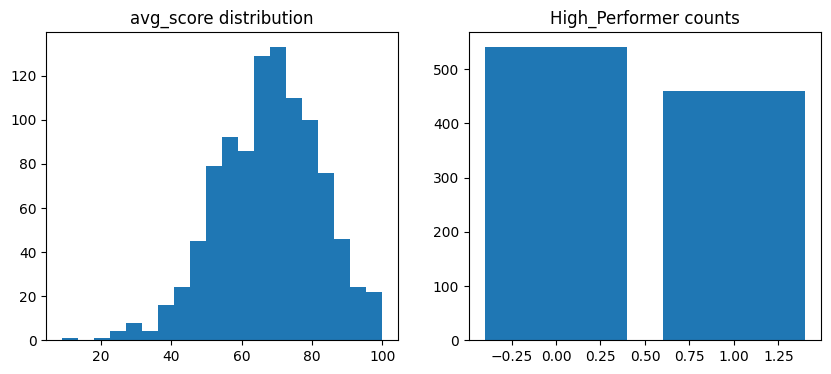

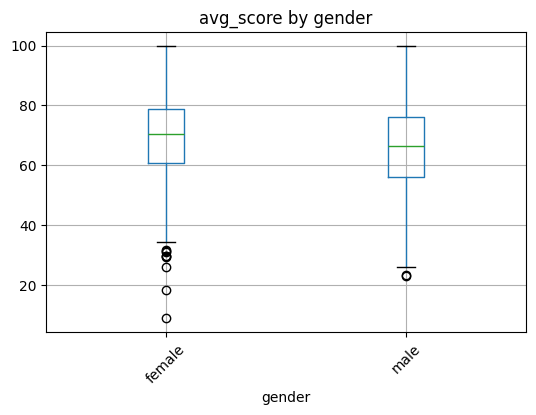

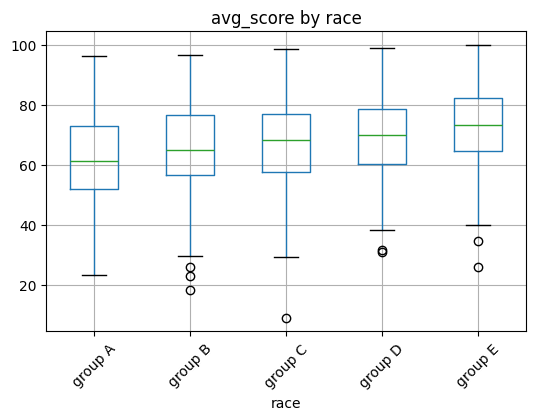

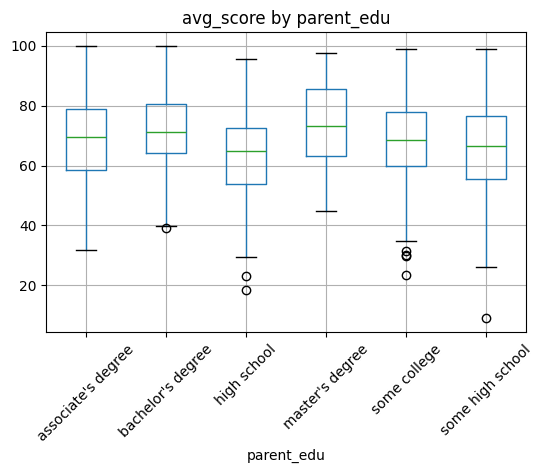

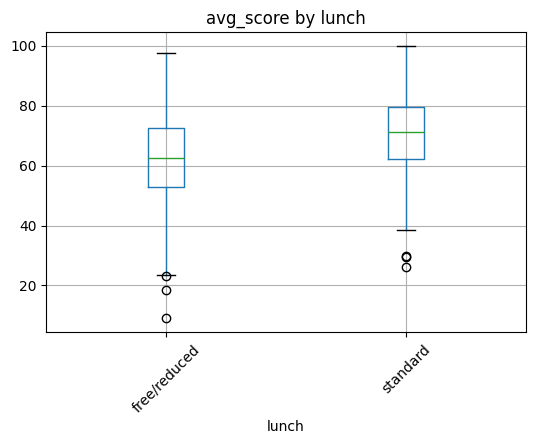

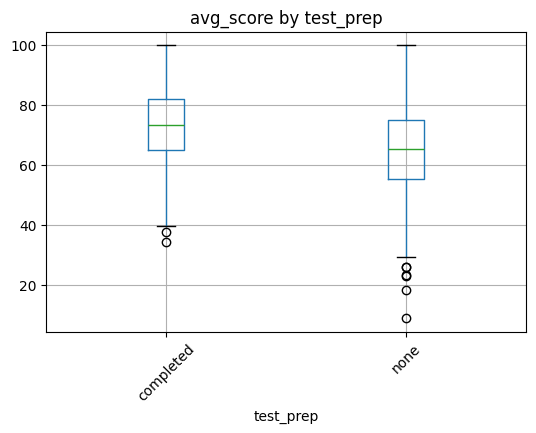

In [3]:
import matplotlib.pyplot as plt

print("Class balance (High_Performer):")
print(y_clf.value_counts(normalize=True).rename("proportion"))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(df["avg_score"], bins=20)
ax[0].set_title("avg_score distribution")
ax[1].bar(df["High_Performer"].value_counts().index, df["High_Performer"].value_counts().values)
ax[1].set_title("High_Performer counts")
plt.show()

# Boxplots by categories
for col in ["gender","race","parent_edu","lunch","test_prep"]:
    df.boxplot(column="avg_score", by=col, rot=45, figsize=(6,4))
    plt.title(f"avg_score by {col}")
    plt.suptitle("")
    plt.show()


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def make_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])
    return pre, num_cols, cat_cols

pre_clf, num_c, cat_c = make_preprocessor(Xc_tr)
pre_reg, num_r, cat_r = make_preprocessor(Xr_tr)

num_c, cat_c


(['math', 'reading', 'writing'],
 ['gender', 'race', 'parent_edu', 'lunch', 'test_prep'])

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

clf_baseline = Pipeline([("prep", pre_clf),
                         ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
clf_baseline.fit(Xc_tr, yc_tr)
yhat_b = clf_baseline.predict(Xc_te)
yprob_b = clf_baseline.predict_proba(Xc_te)[:,1]
print("=== Classification — Baseline (LogReg) ===")
print(classification_report(yc_te, yhat_b, digits=4))
print("ROC-AUC:", f"{roc_auc_score(yc_te, yprob_b):.4f}")

clf_strong = Pipeline([("prep", pre_clf),
                       ("clf", HistGradientBoostingClassifier(random_state=42))])
clf_strong.fit(Xc_tr, yc_tr)
try:
    yprob_s = clf_strong.predict_proba(Xc_te)[:,1]
except Exception:
    try:
        yprob_s = clf_strong.decision_function(Xc_te)
    except Exception:
        yprob_s = None
yhat_s = clf_strong.predict(Xc_te)
print("\n=== Classification — Strong (HGB) ===")
print(classification_report(yc_te, yhat_s, digits=4))
if yprob_s is not None and yprob_s.ndim == 1:
    print("ROC-AUC:", f"{roc_auc_score(yc_te, yprob_s):.4f}")


=== Classification — Baseline (LogReg) ===
              precision    recall  f1-score   support

           0     0.9818    1.0000    0.9908       108
           1     1.0000    0.9783    0.9890        92

    accuracy                         0.9900       200
   macro avg     0.9909    0.9891    0.9899       200
weighted avg     0.9902    0.9900    0.9900       200

ROC-AUC: 1.0000

=== Classification — Strong (HGB) ===
              precision    recall  f1-score   support

           0     0.9727    0.9907    0.9817       108
           1     0.9889    0.9674    0.9780        92

    accuracy                         0.9800       200
   macro avg     0.9808    0.9791    0.9798       200
weighted avg     0.9802    0.9800    0.9800       200

ROC-AUC: 0.9993


In [6]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

reg_baseline = Pipeline([("prep", pre_reg), ("reg", Ridge(alpha=1.0))])
reg_baseline.fit(Xr_tr, yr_tr)
pred_rb = reg_baseline.predict(Xr_te)
print("=== Regression — Baseline (Ridge) ===")
print(f"MAE: {mean_absolute_error(yr_te, pred_rb):.3f}  R2: {r2_score(yr_te, pred_rb):.3f}")

reg_strong = Pipeline([("prep", pre_reg), ("reg", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))])
reg_strong.fit(Xr_tr, yr_tr)
pred_rs = reg_strong.predict(Xr_te)
print("\n=== Regression — Strong (RandomForest) ===")
print(f"MAE: {mean_absolute_error(yr_te, pred_rs):.3f}  R2: {r2_score(yr_te, pred_rs):.3f}")


=== Regression — Baseline (Ridge) ===
MAE: 0.007  R2: 1.000

=== Regression — Strong (RandomForest) ===
MAE: 0.506  R2: 0.994


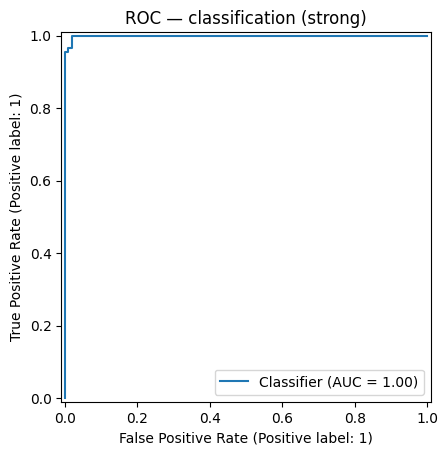

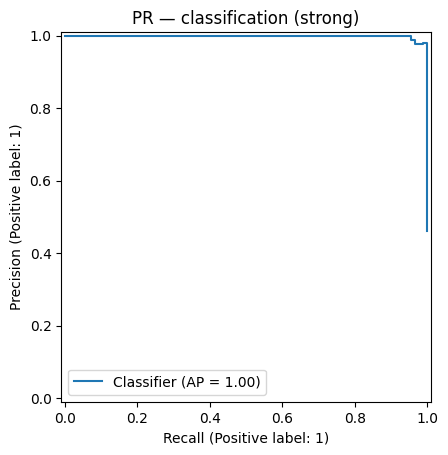

Recall@Top15%: 1.0000


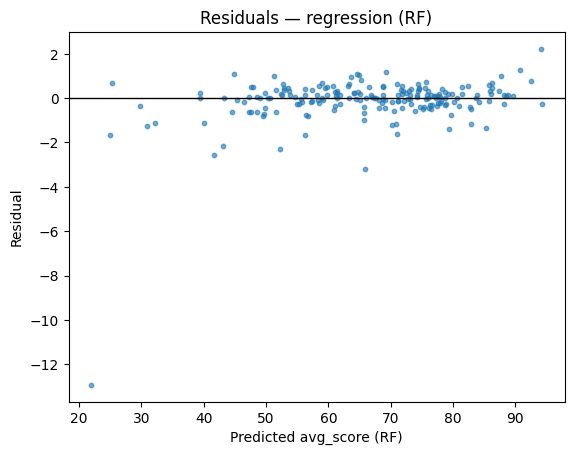

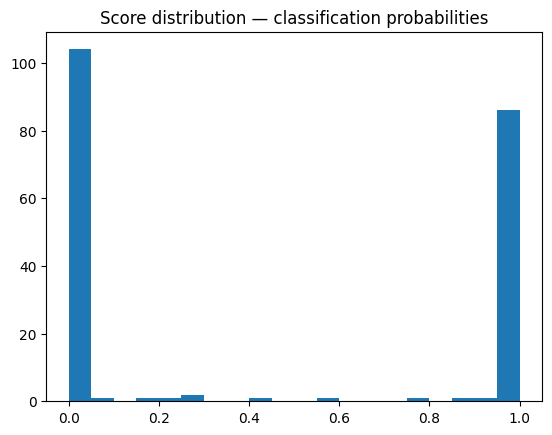

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
import numpy as np

# Classification curves (prefer strong model)
prob = yprob_s if (yprob_s is not None) else yprob_b
RocCurveDisplay.from_predictions(yc_te, prob)
plt.title("ROC — classification (strong)")
plt.show()

PrecisionRecallDisplay.from_predictions(yc_te, prob)
plt.title("PR — classification (strong)")
plt.show()

# Business-style KPI: Recall@TopK (e.g., intervene with top 15% lowest predicted performance)
k = int(0.15 * len(prob))
idx = np.argsort(-prob)[:k]
recall_at_topk = (yc_te.iloc[idx] == 1).mean()
print(f"Recall@Top15%: {recall_at_topk:.4f}")

# Regression residuals
resid = yr_te - pred_rs
plt.scatter(pred_rs, resid, s=10, alpha=0.6)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Predicted avg_score (RF)")
plt.ylabel("Residual")
plt.title("Residuals — regression (RF)")
plt.show()

# Optional: simple calibration for classification
cal = plt.hist(prob, bins=20)
plt.title("Score distribution — classification probabilities")
plt.show()
